In [ ]:
!pip install -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from google.colab import drive
import pandas as pd
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F
from transformers import ViTFeatureExtractor
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
image_directory = '/content/drive/MyDrive/ColonHistology'

In [ ]:
files = os.listdir(image_directory)
files

['Adipose85.tif',
 'Adipose109.tif',
 'Adipose66.tif',
 'Adipose37.tif',
 'Adipose80.tif',
 'Adipose140.tif',
 'Adipose135.tif',
 'Adipose288.tif',
 'Adipose390.tif',
 'Adipose52.tif',
 'Adipose387.tif',
 'Adipose87.tif',
 'Adipose561.tif',
 'Adipose527.tif',
 'Adipose403.tif',
 'Adipose73.tif',
 'Adipose522.tif',
 'Adipose289.tif',
 'Adipose53.tif',
 'Adipose129.tif',
 'Adipose402.tif',
 'Adipose292.tif',
 'Adipose57.tif',
 'Adipose424.tif',
 'Adipose122.tif',
 'Adipose547.tif',
 'Adipose58.tif',
 'Adipose408.tif',
 'Adipose394.tif',
 'Adipose257.tif',
 'Adipose248.tif',
 'Adipose523.tif',
 'Adipose41.tif',
 'Adipose562.tif',
 'Adipose313.tif',
 'Adipose393.tif',
 'Adipose134.tif',
 'Adipose48.tif',
 'Adipose39.tif',
 'Adipose43.tif',
 'Adipose416.tif',
 'Adipose33.tif',
 'Adipose311.tif',
 'Adipose386.tif',
 'Adipose78.tif',
 'Adipose417.tif',
 'Adipose74.tif',
 'Adipose405.tif',
 'Adipose436.tif',
 'Adipose392.tif',
 'Adipose95.tif',
 'Adipose148.tif',
 'Adipose250.tif',
 'Adipose41

In [ ]:
# Create DataFrame from file names and labels
data = []
label_pattern = re.compile(r'^[a-zA-Z]+')

for filename in os.listdir(image_directory):
    if filename.endswith('.tif'):
        match = label_pattern.match(filename)
        if match:
            label = match.group(0)
            full_path = os.path.join(image_directory, filename)
            data.append([full_path, label])

df = pd.DataFrame(data, columns=['file_path', 'class'])

label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])
class_dict = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Classes in the dataset are:", class_dict)


Classes in the dataset are: {'Adipose': 0, 'Complex': 1, 'Debris': 2, 'Empty': 3, 'Lympho': 4, 'Mucosa': 5, 'Stroma': 6, 'Tumor': 7}


In [ ]:
train_val_df, test_df = train_test_split(df, test_size=0.15, stratify=df['class'], random_state=42)

train_df, val_df = train_test_split(train_val_df, test_size=0.0588, stratify=train_val_df['class'], random_state=42)

print(f'Training set size: {len(train_df)}')
print(f'Validation set size: {len(val_df)}')
print(f'Test set size: {len(test_df)}')

Training set size: 4000
Validation set size: 250
Test set size: 750


In [ ]:
class ColonHistologyDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_name = self.dataframe.iloc[idx, 0]
    image = Image.open(img_name).convert('RGB')
    class_label = self.dataframe.iloc[idx, 1]

    if self.transform:
      image = self.transform(image)

    return image, class_label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [ ]:
train_dataset = ColonHistologyDataset(dataframe=train_df, transform=transform)
val_dataset = ColonHistologyDataset(dataframe=val_df, transform=transform)
test_dataset = ColonHistologyDataset(dataframe=test_df, transform=transform)

In [ ]:
class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=8):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
          return logits, loss.item()
        else:
          return logits, None

In [ ]:
EPOCHS = 50
BATCH_SIZE = 10
VAL_BATCH = 1
LEARNING_RATE = 0.000001

In [ ]:
unique_classes = df['class'].unique()

model = ViTForImageClassification(num_labels=len(unique_classes))

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k', do_rescale=False)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

loss_func = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    model.cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Number of train samples:  4000
Number of test samples:  750
Detected Classes are:  {'Adipose': 0, 'Complex': 1, 'Debris': 2, 'Empty': 3, 'Lympho': 4, 'Mucosa': 5, 'Stroma': 6, 'Tumor': 7}
Epoch: 0 | train loss: 1.9836 | test loss: 1.8538 | test accuracy: 0.56 | val loss: 1.8499 | val accuracy: 0.58
Epoch: 1 | train loss: 1.6963 | test loss: 1.5440 | test accuracy: 0.80 | val loss: 1.5387 | val accuracy: 0.80
Epoch: 2 | train loss: 1.4208 | test loss: 1.2989 | test accuracy: 0.86 | val loss: 1.3085 | val accuracy: 0.85
Epoch: 3 | train loss: 1.2049 | test loss: 1.1245 | test accuracy: 0.91 | val loss: 1.1274 | val accuracy: 0.88
Epoch: 4 | train loss: 1.0386 | test loss: 0.9750 | test accuracy: 0.91 | val loss: 0.9787 | val accuracy: 0.90
Epoch: 5 | train loss: 0.8989 | test loss: 0.8556 | test accuracy: 0.93 | val loss: 0.8681 | val accuracy: 0.90
Epoch: 6 | train loss: 0.7915 | test loss: 0.7593 | test accuracy: 0.93 | val loss: 0.7747 | val accuracy: 0.92
Epoch: 7 | train loss: 0.703

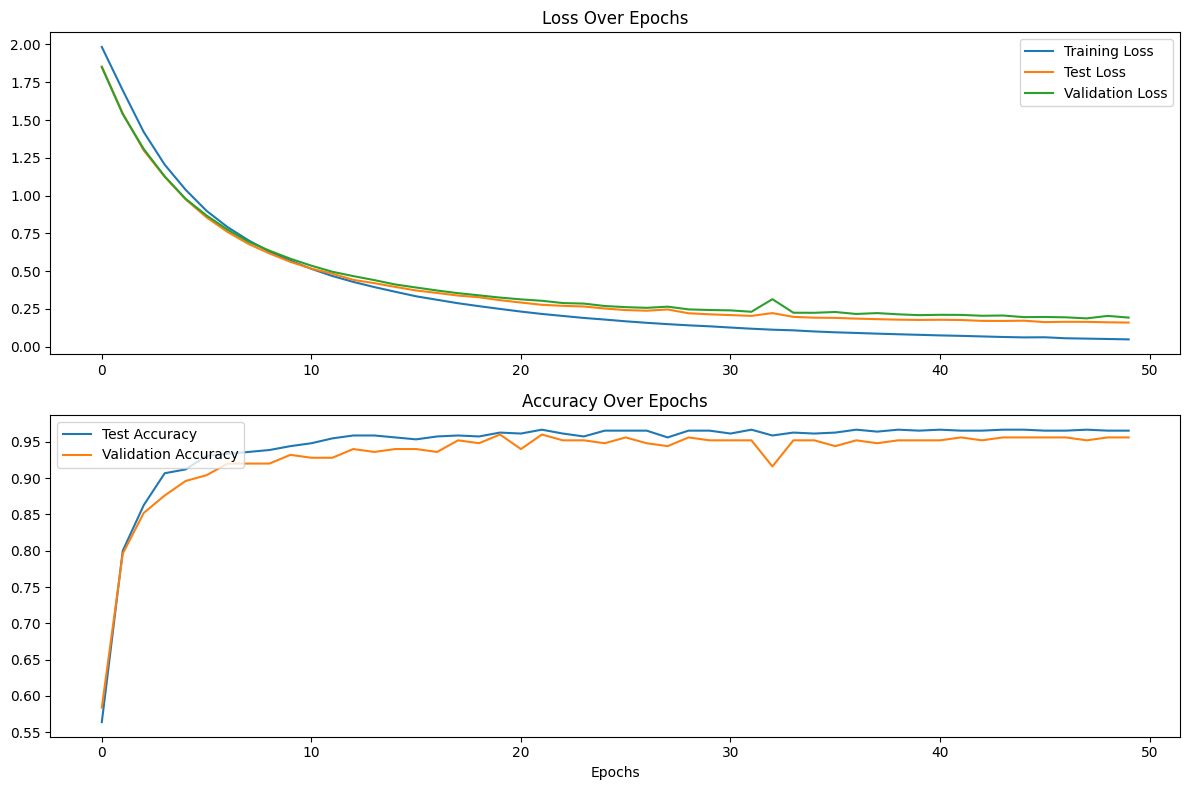

In [ ]:
print("Number of train samples: ", len(train_df))
print("Number of test samples: ", len(test_df))
print("Detected Classes are: ", class_dict)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH, shuffle=True, num_workers=0)

# Lists to store metrics
train_losses = []
test_losses = []
val_losses = []
test_accuracies = []
val_accuracies = []

# Train the model
for epoch in range(EPOCHS):
    train_loss = 0.0
    for step, (x, y) in enumerate(train_loader):
        # Convert batch to numpy array
        x = np.array(x)
        # Apply feature extractor
        features = feature_extractor(x, return_tensors="pt")['pixel_values']
        # Send to GPU if available
        x, y = features.to(device), y.to(device)
        b_x = Variable(x)   # batch x (image)
        b_y = Variable(y)   # batch y (target)
        # Feed through model
        output, loss = model(b_x, None)
        # Calculate loss
        if loss is None:
            loss = loss_func(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss += loss.item() if isinstance(loss, torch.Tensor) else loss

    # Calculate test loss and accuracy
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for test_x, test_y in test_loader:
            # Reshape and get feature matrices as needed
            test_x = feature_extractor(np.array(test_x), return_tensors="pt")['pixel_values']
            test_x = test_x.to(device)
            test_y = test_y.to(device)
            # Generate prediction
            test_output, test_loss_batch = model(test_x, test_y)
            test_loss += test_loss_batch.item() if isinstance(test_loss_batch, torch.Tensor) else test_loss_batch
            # Predicted class value using argmax
            test_predicted_class = test_output.argmax(dim=1)
            test_correct += (test_predicted_class == test_y).sum().item()
            test_total += test_y.size(0)
    test_accuracy = test_correct / test_total
    avg_test_loss = test_loss / len(test_loader)

    # Calculate validation loss and accuracy at the end of each epoch
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_x, val_y in val_loader:
            # Reshape and get feature matrices as needed
            val_x = feature_extractor(np.array(val_x), return_tensors="pt")['pixel_values']
            val_x = val_x.to(device)
            val_y = val_y.to(device)
            # Generate prediction
            val_output, val_loss_batch = model(val_x, val_y)
            val_loss += val_loss_batch.item() if isinstance(val_loss_batch, torch.Tensor) else val_loss_batch
            # Predicted class value using argmax
            val_predicted_class = val_output.argmax(dim=1)
            val_correct += (val_predicted_class == val_y).sum().item()
            val_total += val_y.size(0)
    val_accuracy = val_correct / val_total
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    # Store metrics for plotting
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    val_losses.append(avg_val_loss)
    test_accuracies.append(test_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch: {epoch} | train loss: {avg_train_loss:.4f} | test loss: {avg_test_loss:.4f} | test accuracy: {test_accuracy:.2f} | val loss: {avg_val_loss:.4f} | val accuracy: {val_accuracy:.2f}')

# Plotting the results
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss Over Epochs')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy Over Epochs')

plt.xlabel('Epochs')
plt.tight_layout()
plt.show()


torch.Size([1, 3, 224, 224])


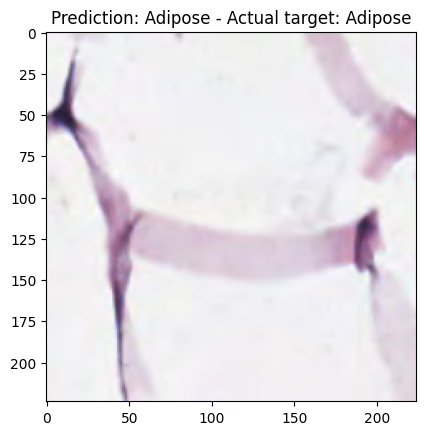

In [ ]:
with torch.no_grad():
    inputs, target = next(iter(val_loader))
    # Reshape and get feature matrices as needed
    print(inputs.shape)
    inputs_np = inputs[0].permute(1, 2, 0).numpy()
    original_input = inputs_np

    inputs = feature_extractor(inputs, return_tensors="pt")['pixel_values']
    inputs = inputs.to(device)
    target = target.to(device)

    # Generate prediction
    prediction, loss = model(inputs, target)

    # Predicted class value using argmax
    predicted_class = prediction.argmax(dim=1).item()
    value_predicted = label_encoder.inverse_transform([predicted_class])[0]
    value_target = label_encoder.inverse_transform(target.cpu().numpy())[0]

    # Show result
    plt.imshow(original_input)
    plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
    plt.show()